In [1]:
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import nltk
import re
from nltk.tokenize import TweetTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import subprocess
import numpy as np 
import pandas as pd 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2024-03-16 22:15:25.548884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 22:15:25.549042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 22:15:25.708238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/traindataset/train.csv


In [2]:
dfs = pd.read_csv("/kaggle/input/traindataset/train.csv")
dfs


,Unnamed: 0.1,Unnamed: 0,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,0,0,3,0,0,3,2,(this text should be deleted) !!! RT @mayasolo...
1,1,1,3,0,3,0,1,(this text should be deleted) !!!!! RT @mleew1...
2,2,2,3,0,3,0,1,(this text should be deleted) !!!!!!! RT @UrKi...
3,3,3,3,0,2,1,1,(this text should be deleted) !!!!!!!!! RT @C_...
4,4,4,6,0,6,0,1,(this text should be deleted) !!!!!!!!!!!!! RT...
...,...,...,...,...,...,...,...,...
24778,24778,24778,3,0,2,1,1,(this text should be deleted) you's a muthaf**...
24779,24779,24779,3,0,1,2,2,(this text should be deleted) you've gone and ...
24780,24780,24780,3,0,3,0,1,(this text should be deleted) young buck wanna...
24781,24781,24781,6,0,6,0,1,(this text should be deleted) youu got wild bi...


In [28]:
random = np.random.randint(0,len(dfs))
print(random)
dfs.iloc[random]['tweet']

85


'text deleted blackman tide whalelookyhere howdydowdy queer gaywad'

In [3]:

nltk.download('stopwords')
nltk.download('punkt')
def clean_text(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    
    # Remove Twitter usernames
    text = re.sub(r'@\w+', '', ' '.join(filtered_words))
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Tokenize using TweetTokenizer
    tokenizer = TweetTokenizer(preserve_case=True)
    text = tokenizer.tokenize(text)
    
    # Remove hashtag symbols
    text = [word.replace('#', '') for word in text]
    
    # Remove short words
    text = ' '.join([word.lower() for word in text if len(word) > 2])
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
dfs['tweet'] = dfs['tweet'].apply(clean_text)


In [5]:
token = Tokenizer(28164)
token.fit_on_texts(dfs['tweet'])
text = token.texts_to_sequences(dfs['tweet'])
text = pad_sequences(text, maxlen=100)

In [6]:
X = dfs['tweet']
y = dfs['class']

In [7]:
from sklearn.model_selection import train_test_split

test_size = 0.20 #20% of the data in the 
X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.20, random_state=42, stratify=y)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(19826, 100) (4957, 100) (19826,) (4957,)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=24071, output_dim=32),
    tf.keras.layers.LSTM(32, dropout=0.2),  # Add dropout to LSTM layer
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  
# Stop training if validation loss does not improve after 3 epochs, restore best weights

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=16, callbacks=[early_stopping])


Epoch 1/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8098 - loss: 0.5533 - val_accuracy: 0.9057 - val_loss: 0.2874
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.9166 - loss: 0.2512 - val_accuracy: 0.9062 - val_loss: 0.2550
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9507 - loss: 0.1538 - val_accuracy: 0.8989 - val_loss: 0.2997


In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9046 - loss: 0.2750
Test Accuracy: 0.9022


In [11]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,y_pred_labels))

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report Testing set


              precision    recall  f1-score   support

           0       0.61      0.21      0.31       286
           1       0.92      0.96      0.94      3838
           2       0.85      0.85      0.85       833

    accuracy                           0.90      4957
   macro avg       0.79      0.68      0.70      4957
weighted avg       0.89      0.90      0.89      4957



In [12]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)

y_train_pred_labels = np.argmax(y_train_pred, axis=1)
print('Classification Report training set')
print('\n')
train_report = classification_report(y_train, y_train_pred_labels)

print(train_report)

620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
Classification Report training set


              precision    recall  f1-score   support

           0       0.77      0.42      0.54      1144
           1       0.95      0.98      0.97     15352
           2       0.94      0.95      0.94      3330

    accuracy                           0.94     19826
   macro avg       0.89      0.78      0.82     19826
weighted avg       0.94      0.94      0.94     19826



155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


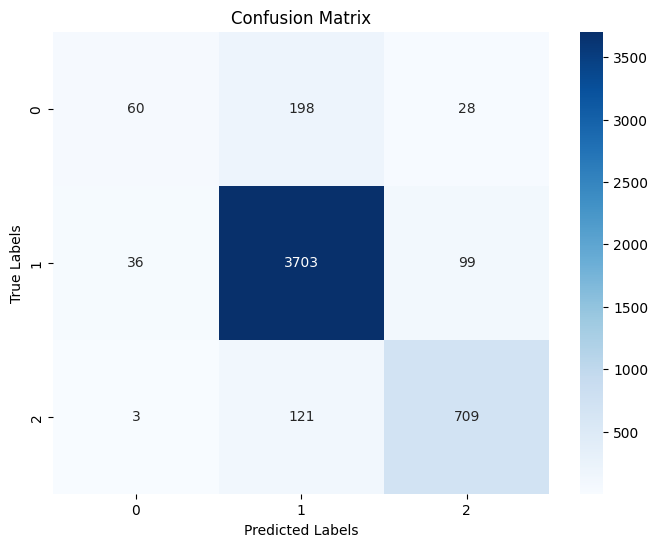

In [13]:

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
